In [2]:
import os
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

NUM_REALIZATIONS = 929
X_CHANNELS = 6
Y_CHANNELS = 2
NX  = 64
NY  = 64
NZ  = 5
NTT = 40
NT0 = 20

sec2year   = 365.25 * 24 * 60 * 60
Darcy      = 9.869233e-13
psi2pascal = 6894.76
co2_rho    = 686.5266
milli      = 1e-3
mega       = 1e6

In [4]:
def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    print('-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('TF version: {} | # Device(s) available: {}'.format(version, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[-1])
    print('-'*60+'\n')
    return None

check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.15.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.2 | cuDNN: 8
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [5]:
deltatime = sio.loadmat('simulations/data/time_arr.mat', simplify_cells=True)['time_arr']
timesteps = np.cumsum(deltatime)
print('timesteps: {} | deltatime: {}'.format(len(timesteps), np.unique(deltatime)))

timesteps: 40 | deltatime: [ 0.5 50. ]


In [6]:
# Load data
X_data = np.load('simulations/data/X_data.npy')
c_data = np.load('simulations/data/c_data.npy')
y1_data = np.load('simulations/data/y1_data.npy')
y2_data = np.load('simulations/data/y2_data.npy')
print('X: {} | c: {}'.format(X_data.shape, c_data.shape))
print('y1: {} | y2: {}'.format(y1_data.shape, y2_data.shape))

# Normalize data
pmu, psd = X_data[...,0].mean(), X_data[...,0].std() # porosity
kmu, ksd = X_data[...,1].mean(), X_data[...,1].std() # permeability
vmu, vsd = X_data[...,3].mean(), X_data[...,3].std() # poreVol
tmi, tma = X_data[...,4].min(),  X_data[...,4].max() # tops
hmi, hma = X_data[...,5].min(),  X_data[...,5].max() # heights
cmi, cma = c_data.min(),         c_data.max()        # controls

X_data[...,0] = (X_data[...,0] - pmu) / (3.33*psd)
X_data[...,1] = (X_data[...,1] - kmu) / (3.33*ksd)
X_data[...,3] = (X_data[...,3] - vmu) / (3.33*vsd)
X_data[...,4] = (X_data[...,4] - tmi) / (tma - tmi)
X_data[...,5] = (X_data[...,5] - hmi) / (hma - hmi)
c_data = c_data / 2.0

y1_data[...,0]  = y1_data[...,0]  / 50e3
y1_data[...,-1] = y1_data[...,-1] / 0.73
y2_data[...,-1] = y2_data[...,-1] / 0.73

print('porosity     - min: {:.2f} | max: {:.2f}'.format(X_data[...,0].min(), X_data[...,0].max()))
print('logperm      - min: {:.2f} | max: {:.2f}'.format(X_data[...,1].min(), X_data[...,1].max()))
print('poreVol      - min: {:.2f} | max: {:.2f}'.format(X_data[...,3].min(), X_data[...,3].max()))
print('tops         - min: {:.2f} | max: {:.2f}'.format(X_data[...,4].min(), X_data[...,4].max()))
print('heights      - min: {:.2f} | max: {:.2f}'.format(X_data[...,5].min(), X_data[...,5].max()))
print('controls     - min: {:.2f} | max: {:.2f}'.format(c_data.min(), c_data.max()))
print('pressure_1   - min: {:.2f} | max: {:.2f}'.format(y1_data[...,0].min(), y1_data[...,0].max()))
print('saturation_1 - min: {:.2f} | max: {:.2f}'.format(y1_data[...,-1].min(), y2_data[...,-1].max()))
print('saturation_2 - min: {:.2f} | max: {:.2f}'.format(y2_data[...,-1].min(), y2_data[...,-1].max()))

X: (929, 64, 64, 6) | c: (929, 20, 5)
y1: (929, 20, 64, 64, 2) | y2: (929, 20, 64, 64, 1)
porosity     - min: -0.62 | max: 2.35
logperm      - min: -2.19 | max: 2.48
poreVol      - min: -0.62 | max: 2.45
tops         - min: 0.00 | max: 1.00
heights      - min: 0.00 | max: 1.00
controls     - min: 0.00 | max: 0.83
pressure_1   - min: 0.08 | max: 0.91
saturation_1 - min: 0.00 | max: 0.94
saturation_2 - min: 0.00 | max: 0.94


In [7]:
train_idx = np.random.choice(range(len(X_data)), 800, replace=False)
test_idx  = np.setdiff1d(range(len(X_data)), train_idx)

X_train = X_data[train_idx]
c_train = c_data[train_idx]
y1_train = y1_data[train_idx]
y2_train = y2_data[train_idx]

X_test = X_data[test_idx]
c_test = c_data[test_idx]
y1_test = y1_data[test_idx]
y2_test = y2_data[test_idx]

print('X_train:  {}     | c_train: {}'.format(X_train.shape, c_train.shape))
print('y1_train: {} | y2_train: {}'.format(y1_train.shape, y2_train.shape))
print('-'*70)
print('X_test:  {}     | c_test: {}'.format(X_test.shape, c_test.shape))
print('y1_test: {} | y2_test: {}'.format(y1_test.shape, y2_test.shape))

X_train:  (800, 64, 64, 6)     | c_train: (800, 20, 5)
y1_train: (800, 20, 64, 64, 2) | y2_train: (800, 20, 64, 64, 1)
----------------------------------------------------------------------
X_test:  (129, 64, 64, 6)     | c_test: (129, 20, 5)
y1_test: (129, 20, 64, 64, 2) | y2_test: (129, 20, 64, 64, 1)


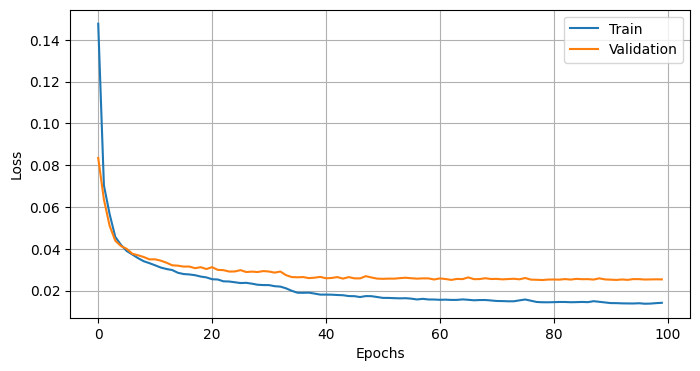

In [39]:
losses = pd.read_csv('pix2vid-v2.csv')
plt.figure(figsize=(8,4))
plt.plot(losses.index, losses['loss'], label='Train')
plt.plot(losses.index, losses['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both')
plt.show()

***
# END